In [ ]:
import torch
import wandb
from hydra.utils import instantiate
from omegaconf import OmegaConf
from torch.utils.data import DataLoader

from runs.config.config import (BenchmarkConfig, CommonConfig, Config,
                                ControlConfig, DecoderConfig, DVIProcessConfig,
                                SetEncoderConfig, TrainingConfig)
from src.components.contextual_dvi import ContextualDVI
from src.components.control import Control
from src.components.decoder import Decoder
from src.components.dvi_process import DiffusionVIProcess
from src.components.encoder import SetEncoder
from src.utils.context_datasets import MetaLearningDataset
from src.utils.train import train
from src.utils.visualize import visualize

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 
print(device)

privateuseone:0


In [3]:
common_config = CommonConfig(
    x_dim = 1,
    y_dim = 1,
    c_dim = 2,
    z_dim = 2,
    h_dim = 128,
    num_layers = 6,
    non_linearity = "Tanh", # "SiLU"
)

set_encoder_config = SetEncoderConfig(
    aggregation="max",
    use_context_size=False,
    is_attentive=True
)

dvi_process_config = DVIProcessConfig(
    _target_="src.dvi_process.DIS",
    num_steps=16
)

control_config = ControlConfig(
    is_cross_attentive=False
)

decoder_config = DecoderConfig(
    has_lat_path=True,
    has_det_path=True,
    is_cross_attentive=False
)

training_config = TrainingConfig(
    num_epochs=2500,
    batch_size=1024,
    learning_rate=3e-4,
    wandb_logging=False
)

benchmark_config = BenchmarkConfig(
    _target_="metalearning_benchmarks.line_sine1d_benchmark.LineSine1D",
    n_task=4096,
    n_datapoints_per_task=64,
    output_noise=0.1,
    seed_task=1237, 
    seed_x=123, 
    seed_noise=1237
)

config = Config(
    common=common_config,
    set_encoder=set_encoder_config,
    dvi_process=dvi_process_config,
    control=control_config,
    decoder=decoder_config,
    training=training_config,
    benchmark=benchmark_config
)

In [4]:
benchmark = instantiate(config.benchmark)
dataset = MetaLearningDataset(benchmark=benchmark)
dataloader = DataLoader(dataset, config.training.batch_size, True)

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 265999.89it/s]


In [5]:
set_encoder = SetEncoder(
    c_dim=config.common.c_dim,
    h_dim=config.common.h_dim,
    num_layers=config.common.num_layers,
    non_linearity=config.common.non_linearity,
    is_attentive=config.set_encoder.is_attentive,
    is_aggregative=not config.control.is_cross_attentive
    or not config.decoder.is_cross_attentive,
    is_non_aggregative=config.control.is_cross_attentive
    or config.decoder.is_cross_attentive,
    use_context_size=config.set_encoder.use_context_size,
    aggregation=config.set_encoder.aggregation,
    max_context_size=dataset.max_context_size,
)

control = Control(
    h_dim=config.common.h_dim,
    z_dim=config.common.z_dim,
    num_layers=config.common.num_layers,
    non_linearity=config.common.non_linearity,
    num_steps=config.dvi_process.num_steps,
    is_cross_attentive=config.control.is_cross_attentive,
)

dvi_process: DiffusionVIProcess = instantiate(
    config.dvi_process,
    z_dim=config.common.z_dim,
    control=control,
    device=device,
)

decoder = Decoder(
    x_dim=config.common.x_dim,
    z_dim=config.common.z_dim,
    h_dim=config.common.h_dim,
    y_dim=config.common.y_dim,
    num_layers=config.common.num_layers,
    non_linearity=config.common.non_linearity,
    has_lat_path=config.decoder.has_lat_path,
    has_det_path=config.decoder.has_det_path,
    is_cross_attentive=config.decoder.is_cross_attentive,
)

contextual_dvi = ContextualDVI(
    encoder=set_encoder,
    dvi_process=dvi_process,
    decoder=decoder,
).to(device)

In [6]:
wandb_logging = False

if wandb_logging:
    wandb.init(project="dvi-bml", config=OmegaConf.to_container(config))

In [7]:
num_epochs = 2500
# params = [
#     {"params": dvi_process.parameters(), "lr": config.learning_rate},
#     {"params": set_encoder.parameters(), "lr": config.learning_rate},
#     {"params": decoder.parameters(), "lr": config.learning_rate}
# ]
optimizer = torch.optim.AdamW(contextual_dvi.parameters(), lr=config.training.learning_rate)

In [ ]:
losses = train(
    device=device, 
    contextual_dvi=contextual_dvi,
    target_constructor=None,
    num_epochs=num_epochs,
    dataloader=dataloader, 
    optimizer=optimizer, 
    scheduler=None,
    wandb_logging=wandb_logging,
)

/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/distributions/normal.py:71: UserWarning: The operator 'aten::normal.Tensor_Tensor' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  return torch.normal(self.loc.expand(shape), self.scale.expand(shape))


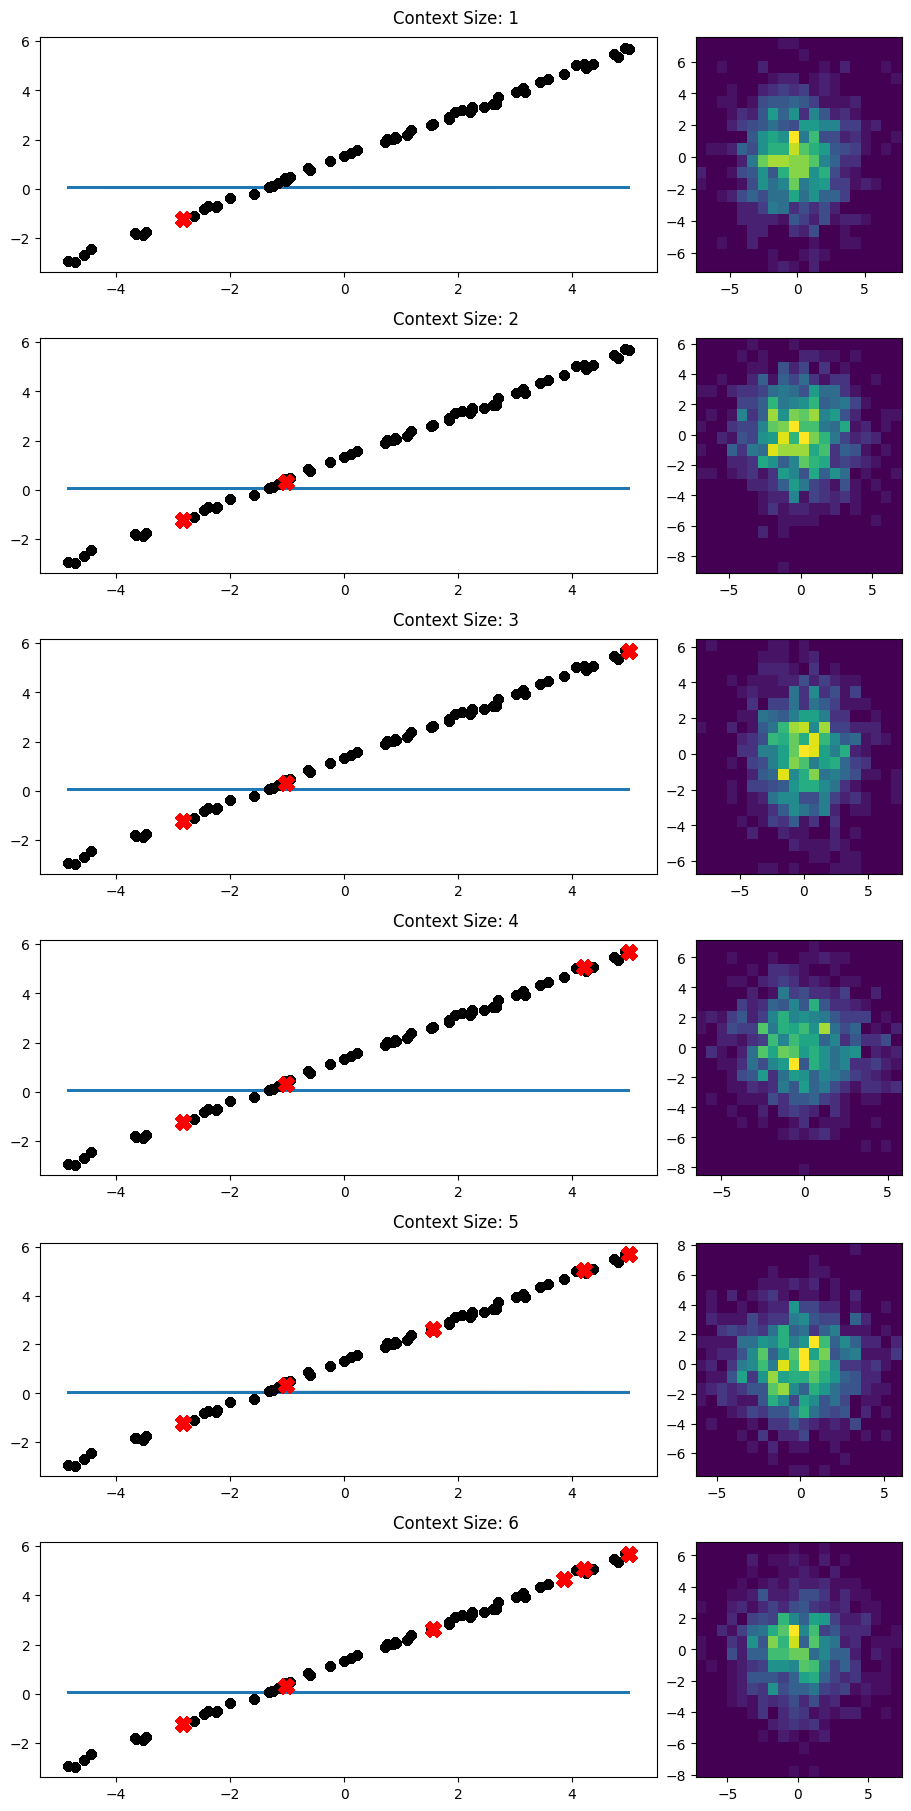

In [8]:
gen_dataloader = DataLoader(dataset, 1, True)

max_context_size = 6
num_samples = 1024

visualize(
    device=device,
    dvi_process=dvi_process,
    set_encoder=set_encoder,
    decoder=decoder,
    dataloader=gen_dataloader,
    control=control,
    config=config,
    num_samples=num_samples,
    max_context_size=max_context_size
)